# Part 2. Digit Recognition

### Using Traditional ML Classifiers (i.e. No DL)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from sklearn.cluster import KMeans
from toolz import pipe
import pandas as pd

In [18]:
from PIL import Image
from numpy import asarray


def imresize(arr,size):
	img=Image.fromarray(arr)
	img=img.resize(size)
	return asarray(img)

train data shape (100, 28, 28)
test data shape (100,)
[[0.6936572  0.03596387 0.6936572  ... 0.03175661 0.01107072 0.        ]
 [0.3689471  0.04998216 0.37799495 ... 0.676992   0.676992   0.23105536]
 [0.3861699  0.         0.27306336 ... 0.4287018  0.1326206  0.30490178]
 ...
 [0.70710677 0.         0.         ... 0.00371873 0.32911333 0.66723806]
 [0.46616748 0.33009034 0.14762087 ... 0.         0.         0.        ]
 [0.39428943 0.         0.39428943 ... 0.00585987 0.6933048  0.6933048 ]]
Accuracy:  0.8181818181818182
loading "digitsTest/Rivers.jpeg for digit recognition" ...
Accuracy:  0.7575757575757576
loading "digitsTest/Rivers.jpeg for digit recognition" ...


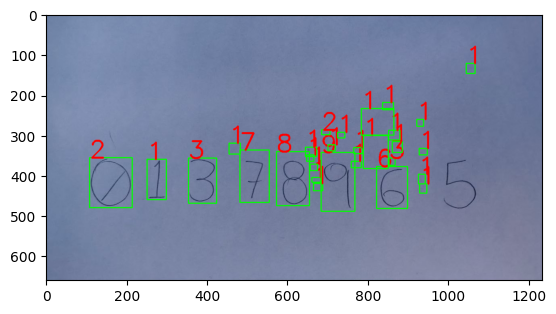

In [23]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 21 14:38:53 2015

@author: Pavitrakumar

"""

import numpy as np
# from scipy.misc.pilutil import imresize
from PIL import Image
import cv2  # version 3.2.0
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

DIGIT_WIDTH = 10
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_N = 10  # 0-9


# This method splits the input training image into small cells (of a single digit) and uses these cells as training data.
# The default training image (MNIST) is a 1000x1000 size image and each digit is of size 10x20. so we divide 1000/10 horizontally and 1000/20 vertically.
def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w // sx) for row in np.vsplit(img, h // sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells


def load_digits(fn):
    print('loading "%s for training" ...' % fn)
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (DIGIT_WIDTH, DIGIT_HEIGHT))
    resized_digits = []
    for digit in digits:
        resized_digits.append(imresize(digit, (IMG_WIDTH, IMG_HEIGHT)))
    labels = np.repeat(np.arange(CLASS_N), len(digits) / CLASS_N)
    return np.array(resized_digits), labels


def pixels_to_hog_20(img_array):
    hog_featuresData = []
    for img in img_array:
        fd = hog(img,
                 orientations=10,
                 pixels_per_cell=(5, 5),
                 cells_per_block=(1, 1))
        hog_featuresData.append(fd)
    hog_features = np.array(hog_featuresData, 'float64')
    return np.float32(hog_features)


# define a custom model in a similar class wrapper with train and predict methods
class KNN_MODEL():
    def __init__(self, k=3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        retval, results, neigh_resp, dists = self.model.findNearest(samples, self.k)
        return results.ravel()


class SVM_MODEL():
    def __init__(self, num_feats, C=1, gamma=0.1):
        self.model = cv2.ml.SVM_create()
        self.model.setType(cv2.ml.SVM_C_SVC)
        self.model.setKernel(cv2.ml.SVM_RBF)  # SVM_LINEAR, SVM_RBF
        self.model.setC(C)
        self.model.setGamma(gamma)
        self.features = num_feats

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        results = self.model.predict(samples.reshape(-1, self.features))
        return results[1].ravel()


def get_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]
    final_bounding_rectangles = []
    # find the most common heirarchy level - that is where our digits's bounding boxes are
    u, indices = np.unique(hierarchy[:, -1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]

    for r, hr in zip(bounding_rectangles, hierarchy):
        x, y, w, h = r
        # this could vary depending on the image you are trying to predict
        # we are trying to extract ONLY the rectangles with images in it (this is a very simple way to do it)
        # we use heirarchy to extract only the boxes that are in the same global level - to avoid digits inside other digits
        # ex: there could be a bounding box inside every 6,9,8 because of the loops in the number's appearence - we don't want that.
        # read more about it here: https://docs.opencv.org/trunk/d9/d8b/tutorial_py_contours_hierarchy.html
        if ((w * h) > 250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy:
            final_bounding_rectangles.append(r)

    return final_bounding_rectangles


def proc_user_img(img_file, model):
    print('loading "%s for digit recognition" ...' % img_file)
    im = cv2.imread(img_file)
    blank_image = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    for rect in digits_rectangles:
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)
        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))

        hog_img_data = pixels_to_hog_20([im_digit])
        pred = model.predict(hog_img_data)
        cv2.putText(im, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
        cv2.putText(blank_image, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)

    plt.imshow(im)
    cv2.imwrite("original_overlay.png", im)
    cv2.imwrite("final_digits.png", blank_image)
    # cv2.destroyAllWindows()


def get_contour_precedence(contour, cols):
    return contour[1] * cols + contour[0]  # row-wise ordering


# this function processes a custom training image
# see example : custom_train.digits.jpg
# if you want to use your own, it should be in a similar format
def load_digits_custom(img_file):
    train_data = []
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 100, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    # sort rectangles accoring to x,y pos so that we can label them
    digits_rectangles.sort(key=lambda x: get_contour_precedence(x, im.shape[1]))

    for index, rect in enumerate(digits_rectangles):
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)

        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class % 10)

        if index > 0 and (index + 1) % 10 == 0:
            start_class += 1
    cv2.imwrite("training_box_overlay.png", im)

    return np.array(train_data), np.array(train_target)


# ------------------data preparation--------------------------------------------

TRAIN_MNIST_IMG = 'digits.png'
#TRAIN_USER_IMG = 'digits/1.jpeg'
TRAIN_USER_IMG = 'custom_train_digits.jpg'
TEST_USER_IMG = 'digitsTest/Rivers.jpeg'

# digits, labels = load_digits(TRAIN_MNIST_IMG) #original MNIST data (not good detection)
digits, labels = load_digits_custom(
    TRAIN_USER_IMG)  # my handwritten dataset (better than MNIST on my handwritten digits)

print('train data shape', digits.shape)
print('test data shape', labels.shape)

digits, labels = shuffle(digits, labels, random_state=256)
train_digits_data = pixels_to_hog_20(digits)
print(train_digits_data)
X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

# ------------------training and testing----------------------------------------

model = KNN_MODEL(k=3)
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, preds))

model = KNN_MODEL(k=4)
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)

model = SVM_MODEL(num_feats=train_digits_data.shape[1])
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, preds))

model = SVM_MODEL(num_feats=train_digits_data.shape[1])
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)

# ------------------------------------------------------------------------------

<hr />

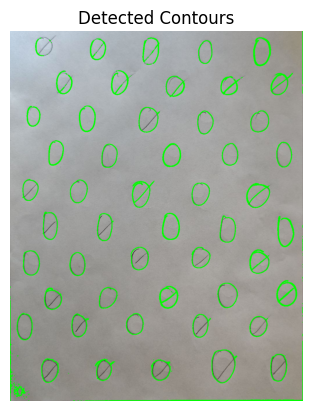

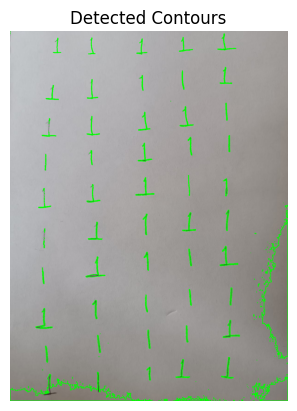

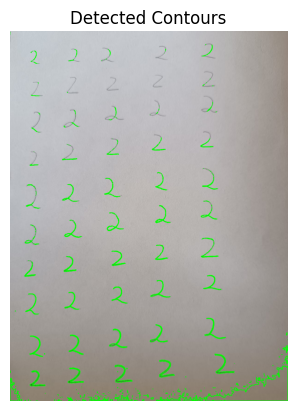

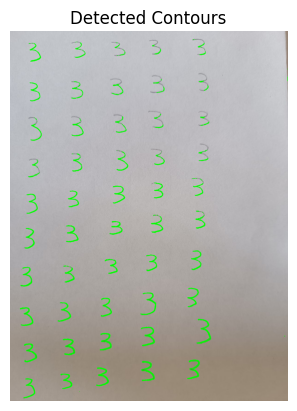

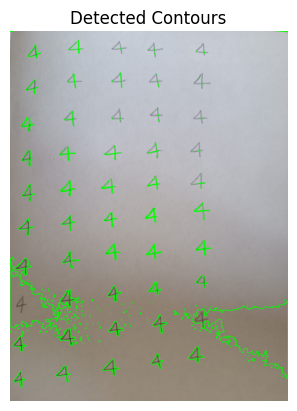

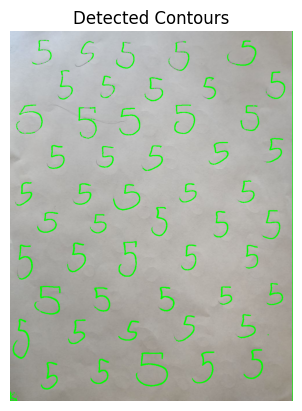

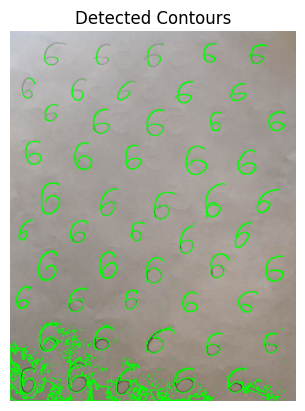

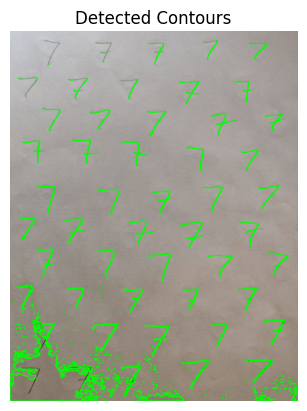

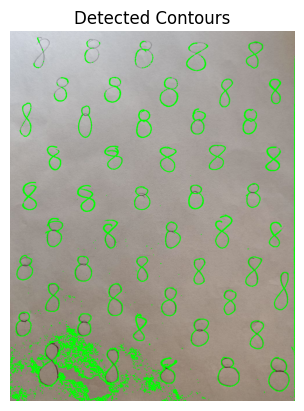

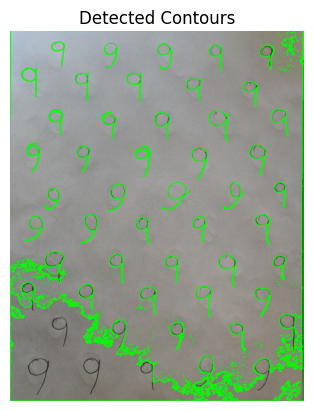

      Digit        Hu1         Hu2       Hu3           Hu4           Hu5  \
0         0   0.000000    0.000000  0.000000  0.000000e+00  0.000000e+00   
1         0   0.000000    0.000000  0.000000  0.000000e+00  0.000000e+00   
2         0   0.000000    0.000000  0.000000  0.000000e+00  0.000000e+00   
3         0   0.000000    0.000000  0.000000  0.000000e+00  0.000000e+00   
4         0   0.000000    0.000000  0.000000  0.000000e+00  0.000000e+00   
...     ...        ...         ...       ...           ...           ...   
6112      9   0.205761    0.012617  0.001576  2.776630e-04  1.704426e-07   
6113      9   0.616927    0.142493  0.003075  2.201725e-01  5.586414e-03   
6114      9   0.187237    0.003168  0.001568  1.607884e-04  6.122536e-08   
6115      9   0.171688    0.001536  0.000553  4.542636e-07 -7.201001e-12   
6116      9  15.061673  226.826032  0.520776  5.202496e-01  2.707965e-01   

               Hu6           Hu7   Euler  
0     0.000000e+00  0.000000e+00     0.0  
1

In [20]:
def get_hu_moments(contour):
    moments = cv2.moments(contour)
    hu_moments = cv2.HuMoments(moments).flatten()
    return hu_moments

def get_euler_number(image):
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    euler_number = num_labels - 1  # Subtract 1 for the background
    return euler_number

def extract_features_and_display(image):
    features = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on the image
    image_contours = image.copy()
    cv2.drawContours(image_contours, contours, -1, (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
    plt.title('Detected Contours')
    plt.axis('off')
    plt.show()
    
    for contour in contours:
#        image_contours = image.copy()
#        cv2.drawContours(image_contours, contour, -1, (0, 255, 0), 2)
#    
#        plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
#        plt.title('Detected Contours')
#        plt.axis('off')
#        plt.show()


        hu_moments = get_hu_moments(contour)
        x, y, w, h = cv2.boundingRect(contour)
        digit_image = binary[y:y+h, x:x+w]
        euler_number = get_euler_number(digit_image)
        features.append(np.append(hu_moments, euler_number))
    
    return features

def process_images_and_display(image_paths, digit_labels):
    all_features = []
    for path, digit in zip(image_paths, digit_labels):
        image = cv2.imread(path)
        features = extract_features_and_display(image)
        for feature in features:
            all_features.append([digit] + feature.tolist())
    return all_features

# Load 10 images (each containing 50 samples)
image_paths = [f"digits/{digit}.jpeg" for digit in range(10)]
digit_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Assuming each image corresponds to a digit from 0 to 9

# Process the images and extract features
features = process_images_and_display(image_paths, digit_labels)

# Create a DataFrame
columns = ['Digit'] + [f'Hu{i+1}' for i in range(7)] + ['Euler']
df = pd.DataFrame(features, columns=columns)

# Save the DataFrame to a CSV file
df.to_csv('digit_features.csv', index=False)

# Output the DataFrame
print(df)


In [21]:

segmentationPipe = lambda file: pipe(
    file,
    readImage,
    kMeansSegmentation,
    extractConnectedComponents,
    computeFeatures
)

In [22]:

segmentationPipe("digits/0.jpeg")

NameError: name 'readImage' is not defined